# Exploring precision and recall

The goal of this second notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.
 

In [51]:
import sframe
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load amazon review dataset

In [52]:
products = sframe.SFrame('amazon_baby.gl/')

In [53]:
products.head()

name,review,rating
Planetwise Flannel Wipes,"These flannel wipes areOK, but in my opinion ...",3.0
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0
Stop Pacifier Suckingwithout tears with ...,"When the Binky Fairy cameto our house, we didn't ...",5.0
A Tale of Baby's Dayswith Peter Rabbit ...,"Lovely book, it's boundtightly so you may no ...",4.0
"Baby Tracker&reg; - DailyChildcare Journal, ...",Perfect for new parents.We were able to keep ...,5.0
"Baby Tracker&reg; - DailyChildcare Journal, ...",A friend of mine pinnedthis product on Pinte ...,5.0
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0


# Extract word counts and sentiments

As in the first assignment of this course, we compute the word counts for individual words and extract positive and negative sentiments from ratings. To summarize, we perform the following:

1. Remove punctuation.
2. Remove reviews with "neutral" sentiment (rating 3).
3. Set reviews with rating 4 or more to be positive and those with 2 or less to be negative.

In [54]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Drop neutral sentiment reviews.
products = products[products['rating'] != 3]

# Positive sentiment to +1 and negative sentiment to -1
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

Now, let's remember what the dataset looks like by taking a quick peek:

In [55]:
products

name,review,rating,review_clean,sentiment
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0,it came early and was notdisappointed i love ...,1
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0,Very soft and comfortableand warmer than it ...,1
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0,This is a product wellworth the purchase I ...,1
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,All of my kids have criednonstop when I tried to ...,1
Stop Pacifier Suckingwithout tears with ...,"When the Binky Fairy cameto our house, we didn't ...",5.0,When the Binky Fairy cameto our house we didnt ...,1
A Tale of Baby's Dayswith Peter Rabbit ...,"Lovely book, it's boundtightly so you may no ...",4.0,Lovely book its boundtightly so you may no ...,1
"Baby Tracker&reg; - DailyChildcare Journal, ...",Perfect for new parents.We were able to keep ...,5.0,Perfect for new parentsWe were able to keep ...,1
"Baby Tracker&reg; - DailyChildcare Journal, ...",A friend of mine pinnedthis product on Pinte ...,5.0,A friend of mine pinnedthis product on Pinte ...,1
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0,This has been an easy wayfor my nanny to record ...,1
"Baby Tracker&reg; - DailyChildcare Journal, ...",I love this journal andour nanny uses it ...,4.0,I love this journal andour nanny uses it ...,1


## Split data into training and test sets

We split the data into a 80-20 split where 80% is in the training set and 20% is in the test set.

In [56]:
train_data, test_data = products.random_split(.8, seed=1)

In [57]:
# calculate the word-count-matrix
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# use this token pattern to keep single-letter words
#first, learn vocabulary from the training data and assign columns to words
#then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
#second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

## Train a logistic regression classifier

We will now train a logistic regression classifier with **sentiment** as the target and **word_count** as the features. We will set `validation_set=None` to make sure everyone gets exactly the same results.  

Remember, even though we now know how to implement logistic regression, we will use GraphLab Create for its efficiency at processing this Amazon dataset in its entirety.  The focus of this assignment is instead on the topic of precision and recall.

In [58]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Model Evaluation

We will explore the advanced model evaluation concepts that were discussed in the lectures.

## Accuracy

One performance metric we will use for our more advanced exploration is accuracy, which we have seen many times in past assignments.  Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

To obtain the accuracy of our trained models using GraphLab Create, simply pass the option `metric='accuracy'` to the `evaluate` function. We compute the **accuracy** of our logistic regression model on the **test_data** as follows:

In [59]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_data['sentiment'].to_numpy(), model.predict(test_matrix))
accuracy

0.93229541636669067

## Baseline: Majority class prediction

Recall from an earlier assignment that we used the **majority class classifier** as a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. The majority classifier model predicts the majority class for all data points. 

Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier can be computed as follows:

In [60]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


** Quiz Question:** Using accuracy as the evaluation metric, was our **logistic regression model** better than the baseline (majority class classifier)?

## Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the **confusion matrix**. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (+1)        |         (-1)         |
+-------+-----+----------------------+----------------------+
| True  |(+1) | # of true positives  | # of false negatives |
| label +-----+----------------------+----------------------+
|       |(-1) | # of false positives | # of true negatives  |
+-------+-----+----------------------+----------------------+
```
To print out the confusion matrix for a classifier, use `metric='confusion_matrix'`:

In [61]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   804
      1       |        1        | 27291


**Quiz Question**: How many predicted values in the **test set** are **false positives**?

In [62]:
1453

1453

## Computing the cost of mistakes


Put yourself in the shoes of a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints.  Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, **false positives cost more than false negatives**. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake: 
1. \$100 for each false positive.
2. \$1 for each false negative.
3. Correctly classified reviews incur no cost.

**Quiz Question**: Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the **test set**?

In [63]:
1453*100+804

146104

## Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher. 

**First**, let us compute the precision of the logistic regression classifier on the **test_data**.

In [64]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].to_numpy(),
                           y_pred=model.predict(test_matrix))
print "Precision on test data: %s"% precision

Precision on test data: 0.949450320067


A complementary metric is **recall**, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

Let us compute the recall on the **test_data**.

In [65]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                     y_pred=model.predict(test_matrix))
print "Recall on test data: %s "%recall

Recall on test data: 0.971382808329 


# Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture.  We first examine what happens when we use a different threshold value for making class predictions.  We then explore a range of threshold values and plot the associated precision-recall curve.  


## Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold. 

Write a function called `apply_threshold` that accepts two things
* `probabilities` (an SArray of probability values)
* `threshold` (a float between 0 and 1).

The function should return an SArray, where each element is set to +1 or -1 depending whether the corresponding probability exceeds `threshold`.

In [66]:
def apply_threshold(probabilities, threshold):
    ### YOUR CODE GOES HERE
    # +1 if >= threshold and -1 otherwise.
    return sframe.SArray(probabilities).apply(lambda x: -1 if x < threshold else 1)

Run prediction with `output_type='probability'` to get the list of probability values. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

In [67]:
probabilities = model.predict_proba(test_matrix)[:,1]
probabilities

array([ 0.78450326,  0.99999924,  0.93319226, ...,  0.99999483,
        0.99999759,  0.98175025])

In [68]:
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_default_threshold

dtype: int
Rows: 33336
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... ]

In [69]:
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)
predictions_with_high_threshold

dtype: int
Rows: 33336
[-1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... ]

In [70]:
print "Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == 1).sum()

Number of positive predicted reviews (threshold = 0.5): 28744


In [71]:
print "Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum()

Number of positive predicted reviews (threshold = 0.9): 25069


**Quiz Question**: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?

## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. We can explore this as follows:

In [72]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].to_numpy(),
                           y_pred=model.predict(test_matrix))
print "Precision on test data: %s"% precision  #default

Precision on test data: 0.949450320067


In [73]:
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_default_threshold

dtype: int
Rows: 33336
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... ]

In [74]:
# Threshold = 0.5
precision_with_default_threshold = precision_score(y_true=test_data['sentiment'].to_numpy(),
                                                   y_pred=predictions_with_default_threshold.to_numpy())

recall_with_default_threshold = recall_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions_with_default_threshold.to_numpy())

# Threshold = 0.9
precision_with_high_threshold = precision_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions_with_high_threshold.to_numpy())
recall_with_high_threshold = recall_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions_with_high_threshold.to_numpy())

In [75]:
print "Precision (threshold = 0.5): %s" % precision_with_default_threshold
print "Recall (threshold = 0.5)   : %s" % recall_with_default_threshold

Precision (threshold = 0.5): 0.949450320067
Recall (threshold = 0.5)   : 0.971382808329


In [76]:
print "Precision (threshold = 0.9): %s" % precision_with_high_threshold
print "Recall (threshold = 0.9)   : %s" % recall_with_high_threshold

Precision (threshold = 0.9): 0.981491084606
Recall (threshold = 0.9)   : 0.875778608293


**Quiz Question (variant 1)**: Does the **precision** increase with a higher threshold?

**Quiz Question (variant 2)**: Does the **recall** increase with a higher threshold?

## Precision-recall curve

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve.

In [77]:
threshold_values = np.linspace(0.5, 1, num=100)
print threshold_values

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

For each of the values of threshold, we compute the precision and recall scores.

In [78]:
# Threshold = 0.5
precision_with_default_threshold = precision_score(y_true=test_data['sentiment'].to_numpy(),
                                                   y_pred=predictions_with_default_threshold.to_numpy())
precision_with_default_threshold

0.94945032006679653

In [79]:
# Threshold = 0.5
recall_with_default_threshold = recall_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions_with_default_threshold.to_numpy())
recall_with_default_threshold

0.97138280832888413

In [81]:
# Threshold = 0.9
precision_with_high_threshold = precision_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions_with_high_threshold.to_numpy())
precision_with_high_threshold 

0.98149108460648615

In [80]:
# Threshold = 0.9
recall_with_high_threshold = recall_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions_with_high_threshold.to_numpy())
recall_with_high_threshold

0.87577860829329057

In [82]:
from sklearn.metrics import recall_score
recall_default = recall_score(y_true=test_data['sentiment'].to_numpy(),
                     y_pred=model.predict(test_matrix))
print "Recall on test data: %s "%recall_default

Recall on test data: 0.971382808329 


In [83]:
precision_all=[]
recall_all=[]
for threshold in threshold_values:
    pred = apply_threshold(probabilities, threshold)
    precision = sum((pred==1)&(test_data['sentiment']==1))/sum(pred==1)
    recall = sum((pred==1)&(test_data['sentiment']==1))/sum(test_data['sentiment']==1)
    print "Precision (threshold =%s): %s"%(threshold, precision)
    print "Recall(threshold =%s) : %s" %(threshold, recall)
    precision_all.append(precision)
    recall_all.append(recall)
       

Precision (threshold =0.5): 0.949450320067
Recall(threshold =0.5) : 0.971382808329
Precision (threshold =0.505050505051): 0.949986068543
Recall(threshold =0.505050505051) : 0.970848905499
Precision (threshold =0.510101010101): 0.950360790602
Recall(threshold =0.510101010101) : 0.970386189713
Precision (threshold =0.515151515152): 0.951003315303
Recall(threshold =0.515151515152) : 0.96995906745
Precision (threshold =0.520202020202): 0.951388161341
Recall(threshold =0.520202020202) : 0.969674319274
Precision (threshold =0.525252525253): 0.951768488746
Recall(threshold =0.525252525253) : 0.969282790532
Precision (threshold =0.530303030303): 0.952186079049
Recall(threshold =0.530303030303) : 0.968962448834
Precision (threshold =0.535353535354): 0.952535965557
Recall(threshold =0.535353535354) : 0.968606513615
Precision (threshold =0.540404040404): 0.952883065929
Recall(threshold =0.540404040404) : 0.968179391351
Precision (threshold =0.545454545455): 0.953168816601
Recall(threshold =0.5454

Precision (threshold =0.90404040404): 0.981856049986
Recall(threshold =0.90404040404) : 0.872539597793
Precision (threshold =0.909090909091): 0.982407407407
Recall(threshold =0.909090909091) : 0.868588716854
Precision (threshold =0.914141414141): 0.982908059943
Recall(threshold =0.914141414141) : 0.863783591386
Precision (threshold =0.919191919192): 0.983274863343
Recall(threshold =0.919191919192) : 0.857946253782
Precision (threshold =0.924242424242): 0.983973041834
Recall(threshold =0.924242424242) : 0.852251290265
Precision (threshold =0.929292929293): 0.984292108753
Recall(threshold =0.929292929293) : 0.845310553479
Precision (threshold =0.934343434343): 0.985100238564
Recall(threshold =0.934343434343) : 0.83776472682
Precision (threshold =0.939393939394): 0.985304674634
Recall(threshold =0.939393939394) : 0.830503648336
Precision (threshold =0.944444444444): 0.986036978522
Recall(threshold =0.944444444444) : 0.821925609539
Precision (threshold =0.949494949495): 0.986732356627
Reca

Now, let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold.

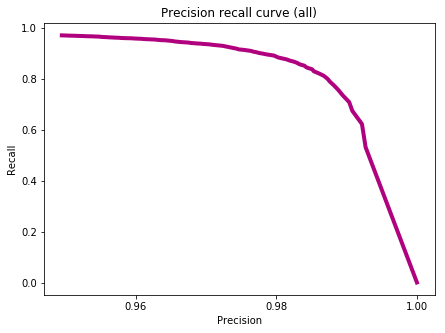

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

**Quiz Question**: Using `threshold` = 0.98, how many **false negatives** do we get on the **test_data**? (**Hint**: You may use the `graphlab.evaluation.confusion_matrix` function implemented in GraphLab Create.)

In [85]:
predictions_98threshold = apply_threshold(probabilities, 0.98)
sum((test_data['sentiment']==1)&(predictions_98threshold==-1))

8210

This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.

# Evaluating specific search terms

So far, we looked at the number of false positives for the **entire test set**. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

## Precision-Recall on all baby related items

From the **test set**, select all the reviews for all products with the word 'baby' in them.

In [86]:
baby_reviews =  test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

In [93]:
#test_data['name'].apply(lambda x: 'baby' in x.lower())

In [87]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])

Now, let's predict the probability of classifying these reviews as positive:

In [88]:
probabilities = model.predict_proba(baby_matrix)[:,1]

Let's plot the precision-recall curve for the **baby_reviews** dataset.

**First**, let's consider the following `threshold_values` ranging from 0.5 to 1:

In [89]:
threshold_values = np.linspace(0.5, 1, num=100)

**Second**, as we did above, let's compute precision and recall for each value in `threshold_values` on the **baby_reviews** dataset.  Complete the code block below.

In [90]:
precision_all = []
recall_all = []

for threshold in threshold_values:
    
    # Make predictions. Use the `apply_threshold` function 
    predictions = apply_threshold(probabilities, threshold)
    # Calculate the precision.
    precision = sum((predictions==1)&(baby_reviews['sentiment']==1))/sum(predictions==1)
    recall = sum((predictions==1)&(baby_reviews['sentiment']==1))/sum(baby_reviews['sentiment']==1)
    print "Precision (threshold = %s): %s" % (threshold, precision)
    print "Recall (threshold = %s) : %s" % (threshold, recall)
    
    # Append the precision and recall scores.
    precision_all.append(precision)
    recall_all.append(recall)

Precision (threshold = 0.5): 0.946657183499
Recall (threshold = 0.5) : 0.967824031994
Precision (threshold = 0.505050505051): 0.947134211463
Recall (threshold = 0.505050505051) : 0.967278676604
Precision (threshold = 0.510101010101): 0.94760292283
Recall (threshold = 0.510101010101) : 0.966551536084
Precision (threshold = 0.515151515152): 0.948420489024
Recall (threshold = 0.515151515152) : 0.966006180694
Precision (threshold = 0.520202020202): 0.948919449902
Recall (threshold = 0.520202020202) : 0.965824395564
Precision (threshold = 0.525252525253): 0.949231319271
Recall (threshold = 0.525252525253) : 0.965279040175
Precision (threshold = 0.530303030303): 0.949713672155
Recall (threshold = 0.530303030303) : 0.964733684785
Precision (threshold = 0.535353535354): 0.949856733524
Recall (threshold = 0.535353535354) : 0.964188329395
Precision (threshold = 0.540404040404): 0.950519899606
Recall (threshold = 0.540404040404) : 0.963824759135
Precision (threshold = 0.545454545455): 0.951031390

Precision (threshold = 0.888888888889): 0.979048006509
Recall (threshold = 0.888888888889) : 0.874931830576
Precision (threshold = 0.893939393939): 0.979779411765
Recall (threshold = 0.893939393939) : 0.872023268497
Precision (threshold = 0.89898989899): 0.980279375514
Recall (threshold = 0.89898989899) : 0.867478640247
Precision (threshold = 0.90404040404): 0.980606560759
Recall (threshold = 0.90404040404) : 0.864024722778
Precision (threshold = 0.909090909091): 0.980928689884
Recall (threshold = 0.909090909091) : 0.860207235048
Precision (threshold = 0.914141414141): 0.981257809246
Recall (threshold = 0.914141414141) : 0.856571532449
Precision (threshold = 0.919191919192): 0.981734201134
Recall (threshold = 0.919191919192) : 0.850027267769
Precision (threshold = 0.924242424242): 0.982667512154
Recall (threshold = 0.924242424242) : 0.84511906926
Precision (threshold = 0.929292929293): 0.982924226254
Recall (threshold = 0.929292929293) : 0.837120523541
Precision (threshold = 0.93434343

**Quiz Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better for the reviews of data in **baby_reviews**? Round your answer to 3 decimal places.

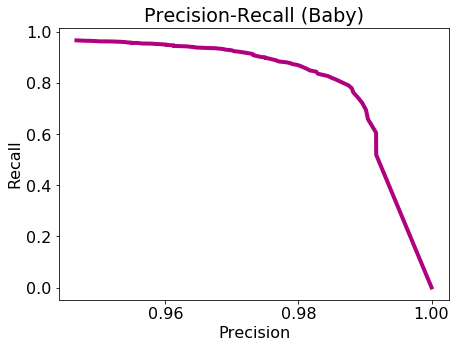

In [91]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")

**Quiz Question:** Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?

**Finally**, let's plot the precision recall curve.